# Gold Mining

## Introduction

Machine learning prototype for Zyfra, a company who develops efficiency solutions for heavy industry. We want to predict the gold recovered from gold ore by using the data on extraction and purification. 


## Data Preprocess

### Objective

Check that recovery is calculated correctly (_rougher.output.recovery_) and find the MAE between your calculations and the feature values.

### Code

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

import joblib

In [97]:
path_array = ['', '/', '/datasets/', './datasets/', '../datasets/']
CSVPATH = None

for i in path_array:
    try:
        pd.read_csv(i + 'gold_recovery_train.csv', nrows=1)
        CSVPATH = i
        break
    except:
        pass

if CSVPATH:
    print('Path found is', 'current folder' if CSVPATH == '' else CSVPATH)
else:
    print('No path found')

Path found is ../datasets/


In [98]:
csv_names = ['train', 'test', 'full']
df = {sheet: pd.read_csv(CSVPATH + 'gold_recovery_' + sheet + '.csv', nrows=1) for sheet in csv_names}

In [99]:
def optimize_types(df):
    df_dtypes = df.dtypes
    df_types = [i.name for i in df_dtypes.values]
    df_types = dict(zip(df.columns, df_types))
    return df_types

float_columns = df['full'].select_dtypes(include=['float64']).columns

for sheet in csv_names:
    for col in float_columns:
        if col in df[sheet]:
            df[sheet][col] = pd.to_numeric(df[sheet][col], downcast = 'float')

int_columns = [ ]
uint_columns = [ ]
bool_columns = [ ]

for sheet in csv_names:
    df_types = {sheet: optimize_types(df[sheet]) for sheet in csv_names}

In [100]:
df = {sheet: pd.read_csv(CSVPATH + 'gold_recovery_' + sheet + '.csv', dtype=df_types[sheet], parse_dates=['date']) for sheet in csv_names}

In [101]:
for sheet in csv_names:
    print('Number of duplicated rows for df ' + sheet + f': {df[sheet][df[sheet].duplicated()].shape[0]}')

Number of duplicated rows for df train: 0
Number of duplicated rows for df test: 0
Number of duplicated rows for df full: 0


In [102]:
for sheet in csv_names:
    print('Number of missing values for df ' + sheet + f': {df[sheet].isnull().sum().sum()}')

Number of missing values for df train: 30320
Number of missing values for df test: 2360
Number of missing values for df full: 36587


In [103]:
print('Top rows with missing values in train df (%):')
(df['train'].isna().sum()/df['train'].shape[0]*100).sort_values(ascending=False).head(10)

Top rows with missing values in train df (%):


rougher.output.recovery               15.260973
rougher.output.tail_ag                13.345196
rougher.output.tail_sol               13.339265
rougher.output.tail_au                13.339265
secondary_cleaner.output.tail_sol     11.779359
rougher.input.floatbank11_xanthate    11.293001
final.output.recovery                  9.021352
primary_cleaner.input.sulfate          7.752076
primary_cleaner.input.depressant       7.485172
rougher.calculation.au_pb_ratio        7.366548
dtype: float64

In [104]:
print('Top rows with missing values in test df (%):')
(df['test'].isna().sum()/df['test'].shape[0]*100).sort_values(ascending=False).head()

Top rows with missing values in test df (%):


rougher.input.floatbank11_xanthate    6.028005
primary_cleaner.input.sulfate         5.157104
primary_cleaner.input.depressant      4.849727
rougher.input.floatbank10_sulfate     4.388661
primary_cleaner.input.xanthate        2.834699
dtype: float64

In [105]:
df['test'] = df['test'].dropna().reset_index(drop=True)

print(f'Number of missing values for df test: {df["test"].isnull().sum().sum()}')

Number of missing values for df test: 0


In [106]:
input_bool_index = df['train'].columns.str.contains('^[a-z+._\d]+input[a-z+._\d]+')
output_bool_index = df['train'].columns.str.contains('^[a-z+._\d]+output[a-z+._\d]+')

df['train'].loc[:,input_bool_index] = (
    df['train'].loc[:, input_bool_index].dropna()
)

In [107]:
df['train']['rougher.output.recovery'].describe()

count    14287.000000
mean        82.394203
std         15.096808
min          0.000000
25%         79.818375
50%         85.236000
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [108]:
df['train'] = df['train'].loc[df['train']['rougher.input.feed_au'].notnull(),:].reset_index(drop=True)

In [109]:
def calc_recovery_rougher(row):
    C = row['rougher.output.concentrate_au'] # gold concentration right after flotation
    F = row['rougher.input.feed_au'] # gold concentration before flotation
    T = row['rougher.output.tail_au'] # gold in tails after flotation
    try:
        result = C * (F - T)/(F * (C - T )) * 100
    except:
        result = np.nan
    if result > 100:
        result = 100
    elif result <= 0:
        result = +0.0
    return result

In [110]:
rougher_recovery = df['train'].apply(calc_recovery_rougher, axis=1)
rougher_recovery.name = 'calculated_rougher_recovery'

In [111]:
display(df['train'][['rougher.output.recovery']].describe().merge(rougher_recovery.describe(), left_index=True, right_index=True))
print('The mean absolute error between provided rougher output recovery and calculated is:\n')
display(
    metrics.mean_absolute_error(
        df['train']['rougher.output.recovery'].fillna(0), 
        rougher_recovery.fillna(0)
        )
    )

,rougher.output.recovery,calculated_rougher_recovery
count,13398.000000,13626.000000
mean,82.736488,82.188717
std,14.644361,16.441922
min,0.000000,0.000000
25%,80.096664,79.970975
50%,85.387611,85.387609
75%,90.171577,90.262583
max,100.000000,100.000000


The mean absolute error between provided rougher output recovery and calculated is:



0.8003950099822875

In [112]:
df['train']['rougher.output.recovery'] = rougher_recovery

In [113]:
df['train'] = df['train'].loc[df['train']['rougher.output.recovery'].notna(), :].reset_index(drop=True)

In [114]:
df['test'].columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [115]:
print('Percentage of missing values per column in train df:')
df['train'].loc[:, df['test'].columns].isna().sum().sort_values(ascending=False).head(10)/df['train'].shape[0]

Percentage of missing values per column in train df:


rougher.state.floatbank10_e_air             0.033465
secondary_cleaner.state.floatbank2_a_air    0.014164
secondary_cleaner.state.floatbank4_a_air    0.000440
secondary_cleaner.state.floatbank2_b_air    0.000367
secondary_cleaner.state.floatbank3_a_air    0.000220
primary_cleaner.state.floatbank8_d_air      0.000147
secondary_cleaner.state.floatbank6_a_air    0.000147
primary_cleaner.state.floatbank8_c_air      0.000073
rougher.input.floatbank10_xanthate          0.000000
rougher.input.floatbank10_sulfate           0.000000
dtype: float64

In [116]:
train_columns = df['test'].columns
train_columns = train_columns.union(['final.output.recovery', 'rougher.output.recovery'])

df['train'] = df['train'].iloc[df['train'].loc[:, train_columns].dropna()['date'].notna().index]

In [117]:
df['train']['date'].describe()

count                   12856
unique                  12856
top       2016-04-22 03:00:00
freq                        1
first     2016-01-15 00:00:00
last      2018-08-18 10:59:59
Name: date, dtype: object

In [118]:
df['train'].loc[:, train_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12856 entries, 0 to 13625
Data columns (total 55 columns):
date                                          12856 non-null datetime64[ns]
final.output.recovery                         12856 non-null float32
primary_cleaner.input.depressant              12856 non-null float32
primary_cleaner.input.feed_size               12856 non-null float32
primary_cleaner.input.sulfate                 12856 non-null float32
primary_cleaner.input.xanthate                12856 non-null float32
primary_cleaner.state.floatbank8_a_air        12856 non-null float32
primary_cleaner.state.floatbank8_a_level      12856 non-null float32
primary_cleaner.state.floatbank8_b_air        12856 non-null float32
primary_cleaner.state.floatbank8_b_level      12856 non-null float32
primary_cleaner.state.floatbank8_c_air        12856 non-null float32
primary_cleaner.state.floatbank8_c_level      12856 non-null float32
primary_cleaner.state.floatbank8_d_air        12856 non-

### Results

From the provided training dataset, we have learned that the recovery is calculated as the ratio of the total weight of the gold ore to the total weight of the gold ore after purification, therefore


## Exploratory Data Analysis


### Objective



### Code

In [119]:
df['train'].corr()['rougher.output.recovery'].sort_values(ascending=False).head(10)

rougher.output.recovery                     1.000000
rougher.output.concentrate_ag               0.637954
rougher.output.concentrate_sol              0.544604
rougher.output.concentrate_pb               0.540503
rougher.output.concentrate_au               0.524924
final.output.recovery                       0.307886
primary_cleaner.input.sulfate               0.261724
secondary_cleaner.state.floatbank4_a_air    0.226983
final.output.tail_ag                        0.220866
secondary_cleaner.state.floatbank4_b_air    0.218239
Name: rougher.output.recovery, dtype: float64

In [120]:
df['train'].corr()['final.output.recovery'].sort_values(ascending=False).head(10)

final.output.recovery                       1.000000
primary_cleaner.input.sulfate               0.382128
rougher.input.feed_ag                       0.320859
rougher.output.recovery                     0.307886
rougher.input.floatbank10_xanthate          0.307614
rougher.input.feed_au                       0.307526
rougher.input.floatbank11_xanthate          0.302062
secondary_cleaner.state.floatbank4_a_air    0.261208
rougher.input.feed_sol                      0.247356
final.output.concentrate_sol                0.246395
Name: final.output.recovery, dtype: float64

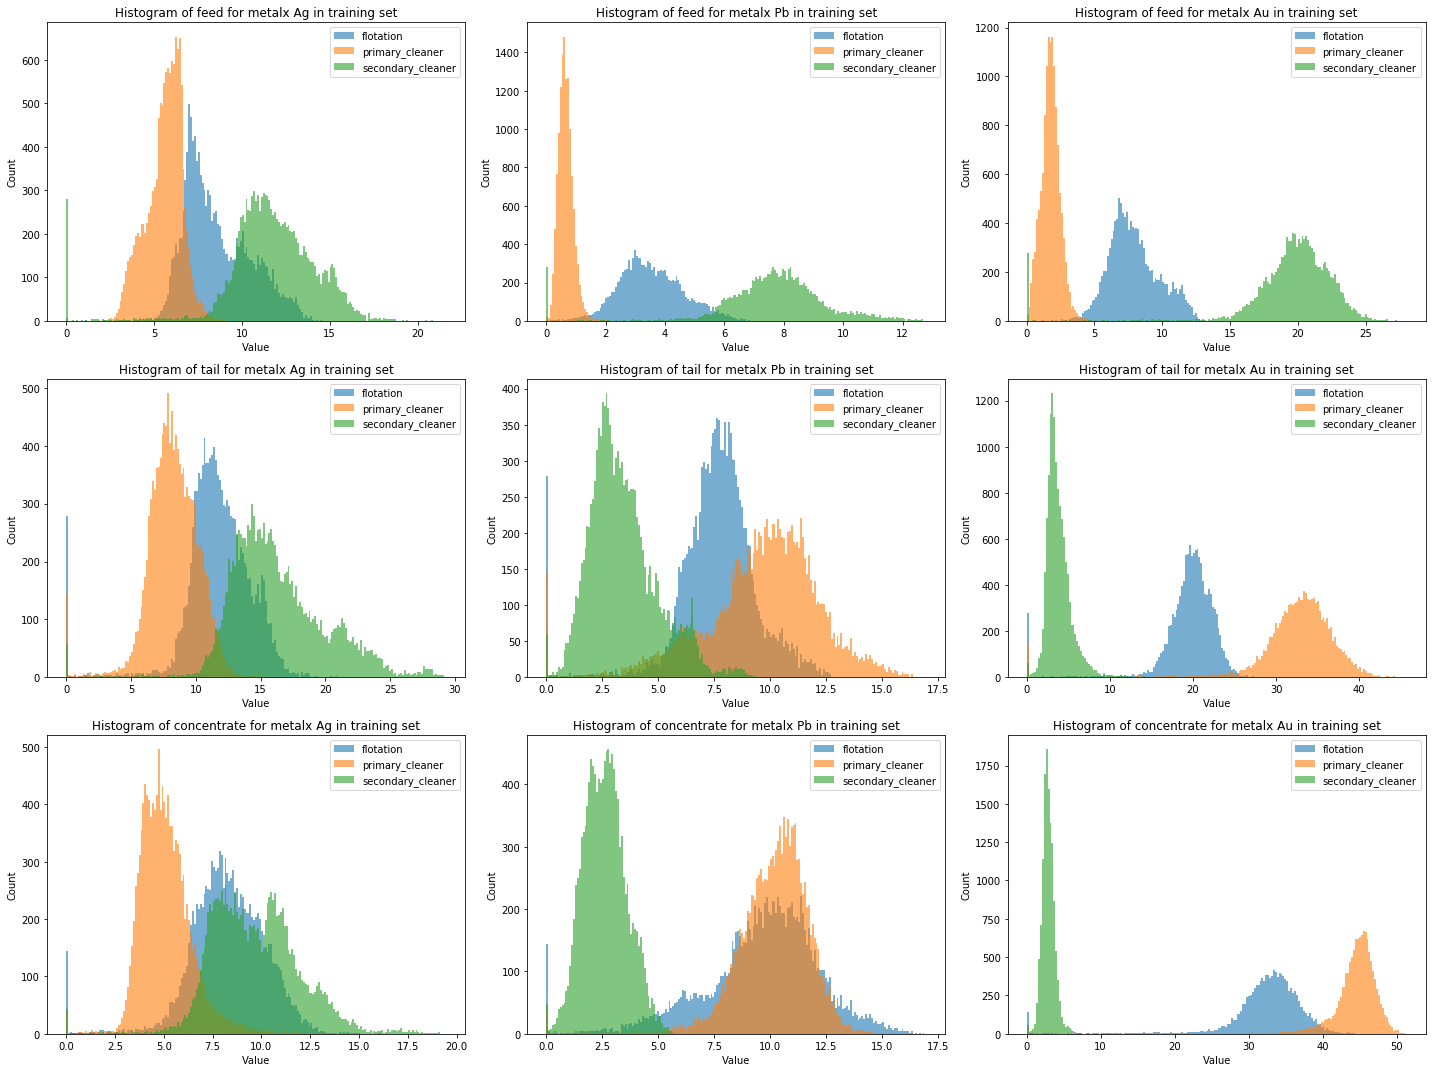

In [121]:
fig, axs = plt.subplots(3,3, figsize=(20, 15))
fig.set_tight_layout(True)

metals = ['ag', 'pb', 'au']
stages = {
    'flotation': ['rougher.input.feed_',  'rougher.output.tail_', 'rougher.output.concentrate_'], 
    
    'primary_cleaner': ['rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'primary_cleaner.output.tail_'],
    
    'secondary_cleaner': ['primary_cleaner.output.concentrate_', 'final.output.concentrate_', 'final.output.tail_']
}
legend = ['flotation', 'primary_cleaner', 'secondary_cleaner']

for stage, c_i, type in zip(legend, range(len(stages)), ['feed', 'tail', 'concentrate']):
    for metal, m_i in zip(metals, range(len(metals))):
        maxrange = 0
        for col in stages[stage]:
            compare = abs(df['train'][col + metal].max() - df['train'][col + metal].min())
            if compare > maxrange:
                maxrange = compare
                bin_set = col
        bin = np.arange(df['train'][bin_set + metal].min(), df['train'][bin_set + metal].max(), maxrange/200)
        for col in stages[stage]:
            axs[c_i, m_i].hist(df['train'][col + metal], bins=bin, alpha=0.6)
            axs[c_i, m_i].set_title('Histogram of ' + type + ' for metal ' + str.capitalize(metal) + ' in training set')
            axs[c_i, m_i].legend(legend)
            axs[c_i, m_i].set_xlabel('Value')
            axs[c_i, m_i].set_ylabel('Count')
            


plt.show()
    

*Graph Analysis*

By looking at the graphs above...

In [122]:
for stage in stages:
    for i in range(3):
        df['train'] = df['train'][df['train'][stages[stage][i] + 'au'] > 0.1]

In [123]:
feed_size = pd.concat([df['train']['rougher.input.feed_size'], df['test']['rougher.input.feed_size']], axis=1)

feed_size.describe()

,rougher.input.feed_size,rougher.input.feed_size
count,12311.000000,5383.000000
mean,58.440754,56.338642
std,20.639158,21.836788
min,9.659576,0.046369
25%,48.761467,43.913765
50%,54.700996,50.924232
75%,63.696865,62.364983
max,484.967468,477.445465


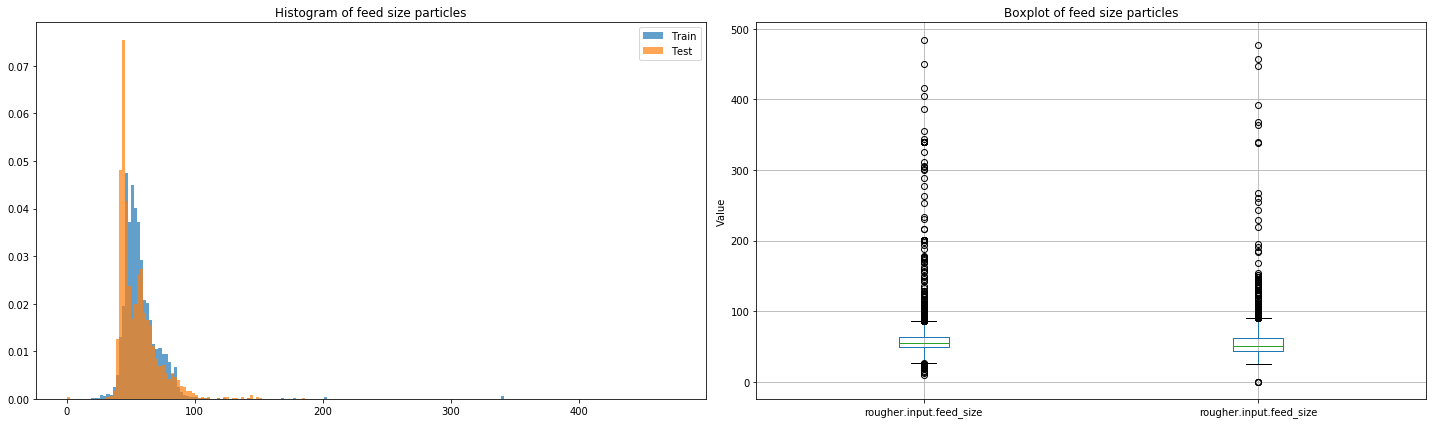

In [124]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
fig.set_tight_layout(True)

feed_size.boxplot()
axs[1].set_title('Boxplot of feed size particles')
axs[1].set_ylabel('Value')

for i in ['train', 'test']:
    compare = abs(df[i]['rougher.input.feed_size'].max() - df[i]['rougher.input.feed_size'].min())
    if compare > maxrange:
        maxrange = compare
        bin_set = i
bin = np.arange(df[i]['rougher.input.feed_size'].min(), df[i]['rougher.input.feed_size'].max(), maxrange/200)

for i in ['train', 'test']:
    axs[0].hist(df[i]['rougher.input.feed_size'], bins=bin, density=True, alpha=0.7)
axs[0].set_title('Histogram of feed size particles')
axs[0].legend(['Train', 'Test'])

plt.show()

*Graph Analysis*

By looking at the...

In [125]:
for i in stages:
    	df['train'] =  df['train'][ (df['train'][ stages[i][0] + 'au' ] > 0) & (df['train'][stages[i][1] + 'au'] > 0) ]

### Results

## Model Training

### Objective

### Code

In [126]:
train = df['train'].loc[:, train_columns].copy()
test = df['test']

In [127]:
def target_features(df, tar_col, remove=[]):
    target = df[tar_col]
    remove.append(tar_col)
    features = df[[x for x in df if x not in remove]]
    return target, features

In [128]:
def find_level(model, param, level=10):
    best = {
        'i': -1, 
        'score': -1
    }
    for i in range(1, level+1):
        setattr(model, param, i)
        model.fit(train_feat, train_target)
        score = model.score(valid_feat, valid_target)
        if (score - best['score']) > 0.001:
            best['score'] = score
            best['i'] = i
    return best['score'], best['i']

def report(target, features=None, predictions=None, model=None, predictions_proba=None, classifier=True):
    """
    Prints a report of the model's performance. If regressor, add classifier=False
    """
    flag = 0
    if model != None:
        if predictions is not None:
            warnings.warn('Both model and predictions were passed. Ignoring model.')
        else:
            if features is None:
                raise ValueError('Features must be passed if model is passed.')
            predictions = model.predict(features)
            if classifier == True:
                predictions_proba = model.predict_proba(features)
    if predictions is not None:
        if classifier == True:
            print(f'Accuracy: {metrics.accuracy_score(target,predictions):.2%}') 
            print(f'Recall: {metrics.recall_score(target,predictions):.2%}')
            print(f'Precision: {metrics.precision_score(target,predictions):.2%}')
            print(f'F1 Score: {metrics.f1_score(target,predictions):.2%}')
        elif classifier == False:
            print(f'Mean Absolute Error: {metrics.mean_absolute_error(target,predictions):.2f}')
            print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(target,predictions)):.2f}') 
            print(f'R2 Score: {metrics.r2_score(target,predictions):.2f}')
            print(f'Predictions mean value: {np.mean(predictions):.2f} (Target mean is {np.mean(target):.2f})')
            print(f'Predictions median value: {np.median(predictions):.2f} (Target median is {np.median(target):.2f})')
            target = pd.Series(target).reset_index(drop=True).sort_values()
            predictions = pd.Series(predictions)
            predictions = predictions.iloc[target.index].reset_index(drop=True)
            target = target.reset_index(drop=True)
            plt.plot(predictions, label='Predicted')
            plt.plot(target, label='Actual', color='orange')
            plt.legend(['Predicted', 'Actual'])
            plt.xlabel('Sample Number')
            plt.show()
    if predictions_proba is not None:
        fpr, tpr, thresholds = metrics.roc_curve(target, predictions_proba[:,1])
        print(f'AUC-ROC: {metrics.roc_auc_score(target,predictions_proba[:,1]):.2%}')
        flag = 1
    if flag == 1:
        return fpr, tpr, thresholds, predictions
    else:
        return predictions

In [129]:
train_target = []
train_feat = []

x, y = target_features(train, 'rougher.output.recovery', remove=['final.output.recovery', 'date'])
train_target.append(x)
train_feat.append(y)

x, y = target_features(train, 'final.output.recovery', remove=['date'])
train_target.append(x)
train_feat.append(y)

In [130]:
full_test = pd.concat([df['full'], df['test']], axis=0).reset_index(drop=True)
full_test_index = full_test.loc[:, df['test'].columns].duplicated(keep='last')
valid = full_test.loc[full_test_index, train_columns].dropna()

print('Size of validation dataset is ' + str(valid.shape[0]))

valid_target = []
valid_feat = []

x, y = target_features(valid, 'rougher.output.recovery', remove=['final.output.recovery', 'date'])
valid_target.append(x)
valid_feat.append(y)

x, y = target_features(valid, 'final.output.recovery', remove=['date'])
valid_target.append(x)
valid_feat.append(y)

Size of validation dataset is 5229


Report of linear model for 1:
Mean Absolute Error: 5.56
Root Mean Squared Error: 12.64
R2 Score: 0.04
Predictions mean value: 85.30 (Target mean is 85.13)
Predictions median value: 84.70 (Target median is 87.42)


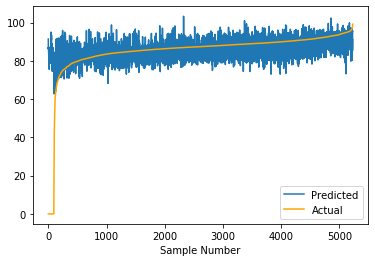



Report of linear model for 2:
Mean Absolute Error: 5.58
Root Mean Squared Error: 9.34
R2 Score: -0.12
Predictions mean value: 68.57 (Target mean is 68.66)
Predictions median value: 69.70 (Target median is 69.86)


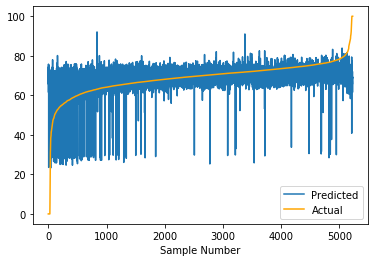

In [131]:
# Launching linear model
linear_model = []
for i in range(2):
    linear_model.append(LinearRegression(normalize=True))

valid_predict = []
for i in range(2):
    print(f'Report of linear model for {i+1}:')
    linear_model[i].fit(train_feat[i], train_target[i])
    valid_predict.append(report(valid_target[i], features=valid_feat[i], model=linear_model[i], classifier=False))
    print('\n')

### Results

## Viability Study

### Objective

### Code

In [ ]:
cost_per_well = 100 * 10**6 / 200
barrels_to_pay_itself = cost_per_well / 4.5
production_to_pay_itself = barrels_to_pay_itself / 1000

print(f'Cost per well: {int(cost_per_well):,} USD')
print(f'Each well must produce at least {production_to_pay_itself:.2f} thousand barrels on average to pay for itself ({production_to_pay_itself*4500:,.0f} USD)')
for i in range(3):
    print(f'The average production of Region {i+1} is {df[i]["product"].mean():.2f} thousand of barrels ({df[i]["product"].mean()*4500:,.0f} USD) ')

In [ ]:
def revenue(wells, quantity):
    profit = wells[:quantity].sum() * 4500
    return profit

In [ ]:
state = np.random.RandomState(1995)

for j in range(3):
    values = []
    values2 = [] 
    for i in range(1000):
        subsample = df[j].sample(n=500, replace=True, random_state=state)
        predict = linear_model[j].predict(subsample[['f0', 'f1', 'f2']])
        predict = pd.Series(predict)
        predict.index = subsample.index
        predict = predict.sort_values(ascending=False)
        values.append(
            revenue(
                df[j].loc[predict.index]['product'],
                200
                )
            )
        values2.append(
            revenue(
                subsample.sort_values(by='f2', ascending=False)['product'],
                200
            )
        )
    
    values = pd.Series(values)
    values2 = pd.Series(values2)
    
    plt.figure(figsize=(10,5))
    plt.hist(values, bins=100, alpha=0.5)
    plt.hist(values2, bins=100, alpha=0.5)
    plt.title(f'Histogram of revenue for Region {j+1}, pick based on ML or f2')
    plt.legend(['Picks by model', 'Picks by f2'])
    plt.show()
    
    print(f'Average profit using ML model : {values.mean() - 100000000:,.2f} USD (as opposed to average profit of {values2.mean() - 100000000:,.2f} USD by picking based on f2)')
    print(f'Average well production using ML model is: {values.mean()/4500/200:,.2f} thousand barrels')
    print(f'Risk of losses by using ML model is {values.where(values < 10**8).dropna().shape[0]/values.shape[0]:.2%} (as opposed to  {values2.where(values2 < 10**8).dropna().shape[0]/values2.shape[0]:.2%} by picking based on f2)')
    print(f'Confidence interval of revenue by using ML model is: {values.quantile(0.025):,.2f} USD to {values.quantile(0.975):,.2f} USD')


*Graph Analysis*

The main findings of this simulation are listed below:

    - Picking oill wells at random from the 500 points for each region will generally result in big losses.
    - The linear model predictions are mainly based on values of feature "f2".
    - Regions 1 and 3 have oil wells with higher values for production, but they are harder to identify.
    - Region 2 has the bet compromise of value with lower risks of losses. Therefore, it is the best region for exploration.
    - The risks of losses are only 1.80% for Region 2, while risks are much higher for other Regions.

### Results

## Conclusion